# 7 Generative AI



### 00 General Setup

We provide you with the data loading framework, training, and validation code. 
If you are interested in how to streamline this process, feel free to look at <a href="https://lightning.ai/docs/pytorch/stable/">Pytorch Lightning</a>.


In [1]:
# Please install this by running this cell or use the requirements.txt again
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: C:\Users\SWATHI.TR\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as TT
from torchsummary import summary

import numpy as np 
import matplotlib.pyplot as plt

from vll.train.VAE_utils import train, validate, plot_training
from typing import List, Optional


# Change this if you have memory problems
batch_size = 64
test_batch_size = 1000

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

print('Running on CUDA' if use_cuda else 'Running on CPU')

Running on CPU


## 01 Setup AE (6P)

In this subtask, you are asked to set up a basic Auto Encoder (AE). This will establish the basics for the following exercises. 

We will implement a Convolutional AE since we are working with image data.
Each Layer of the AE Encoder should consist of a 2D Convolution with a kernel size of 3 and a stride of 2 (padding is set to 1). This means the image resolution will be reduced by two after each layer. 
A 2D BatchNorm and a LeakyReLU follow the 2D Convolution. 

The channels should be transformed in the following way: [input, 32, 64, 128, 256] 

For the Decoder, we use 2D Transposed Convolutions (padding and output_padding ist again 1) instead of Convolutions. We mirror the following channels: [256, 128, 64, 32]. 
For the final layer of the Decoder, we add after a Leaky ReLU a resizing (TT.Resize((28, 28))) followed by another 2D Convolution, which reduces the Channels to the number of output Channels (in our case 1) and a stride of 1 as well as kernel size of 1 (padding to 0). 
A tanh activation follows this. 


![alt text](data/AE_CompVisionEx7.png "AE Structure")

In [3]:
class Vanilla_AE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 input_size: np.ndarray,
                 hidden_dims: List = None,
                 **kwargs) -> None:
    
        super(Vanilla_AE, self).__init__()
        
        self.input_size = input_size
        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            self.hidden_dims = [32, 64, 128, 256]
        else: 
            self.hidden_dims = hidden_dims

        # Build Encoder
        for h_dim in self.hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim

        # Save complete Encoder Sequential as self.encoder
        self.encoder = nn.Sequential(*modules)

        # Calculate the image resolution after the encoding layers
        self.block_dimension = self.input_size 
        for i in range(len(self.hidden_dims)): 
            self.block_dimension = (self.block_dimension + 2 - 1) // 2

        self.fc_mu = nn.Linear(self.hidden_dims[-1] * self.block_dimension[0] * self.block_dimension[1], latent_dim)

        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, self.hidden_dims[-1] * self.block_dimension[0] * self.block_dimension[1])

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1], kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU()
                )
            )

        self.decoder = nn.Sequential(*modules)

        # Final Layer
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], hidden_dims[-1], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            TT.Resize((28, 28)),
            nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=1, padding=0),
            nn.Tanh()
        )

    def encode(self, input: Tensor) -> Tensor:
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        return mu

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, self.hidden_dims[0], self.block_dimension[0], self.block_dimension[1])
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        z = self.encode(input)
        reconstruction = self.decode(z)
        return [reconstruction, input, z]

    def loss_function(self,
                      prediction: List[Tensor], # This is what you return in forward!
                      target: Tensor, 
                      **kwargs) -> dict:
        """
        Computes the AE loss function.
        AE: Just simple MSE_loss
        """
        reconstruction = prediction[0]
        mse_loss = nn.MSELoss()
        loss = mse_loss(reconstruction, target)
        return loss


In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as TT
from torchsummary import summary

import numpy as np 
import matplotlib.pyplot as plt

from vll.train.VAE_utils import train, validate, plot_training
from typing import List, Optional


# Change this if you have memory problems
batch_size = 64
test_batch_size = 1000

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

print('Running on CUDA' if use_cuda else 'Running on CPU')

Running on CPU


C:\Users\SWATHI.TR\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
       BatchNorm2d-2           [-1, 32, 14, 14]              64
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,496
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
        LeakyReLU-12            [-1, 256, 2, 2]               0
           Linear-13                    [-1, 2]           2,050
           Linear-14                 [-

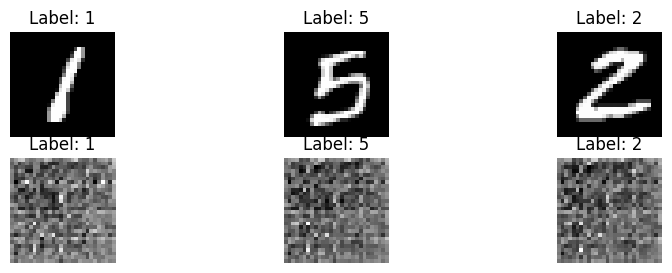

In [5]:
# Test your implementation
# You should see the original MNIST images and 2 noisy images below (since the AE is not trained yet)

AE_model = Vanilla_AE(in_channels=1, latent_dim=2, input_size=np.array([28, 28]), hidden_dims=[32, 64, 128, 256])

summary(AE_model, input_size=(1, 28, 28), device='cpu')


data_instance = iter(train_loader)
images, labels = next(data_instance)


predicted_img, input, z = AE_model(images)

fig, axes = plt.subplots(2, 3, figsize=(10, 3))
for i in range(3):
    image = images[i].numpy().squeeze()  # Bild in numpy-Array umwandeln und Kanal dimension entfernen
    axes[0][i].imshow(image, cmap='gray')
    axes[0][i].set_title(f'Label: {labels[i].item()}')
    axes[0][i].axis('off')
    # Same for prediction
    pred_img = predicted_img[i].detach().numpy().squeeze()
    axes[1][i].imshow(pred_img, cmap='gray')
    axes[1][i].set_title(f'Label: {labels[i].item()}')
    axes[1][i].axis('off')
plt.show()



Test set: Average loss: 0.00104330

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.21647501
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.57944363
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.56604105
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.54038447
Train Epoch: 1 	 Average: 0.00907622

Test set: Average loss: 0.00056196

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.59166658
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.57100534
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.55532414
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.52531534
Train Epoch: 2 	 Average: 0.00850676

Test set: Average loss: 0.00054823



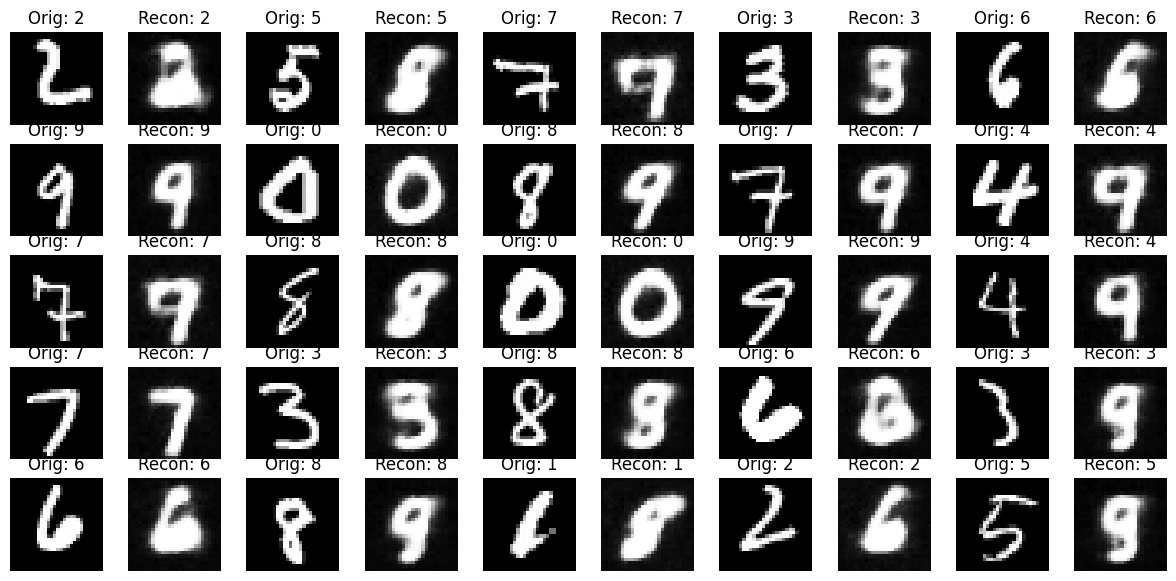

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.52188396
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.51288378
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.53720903
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.52009660
Train Epoch: 3 	 Average: 0.00834537


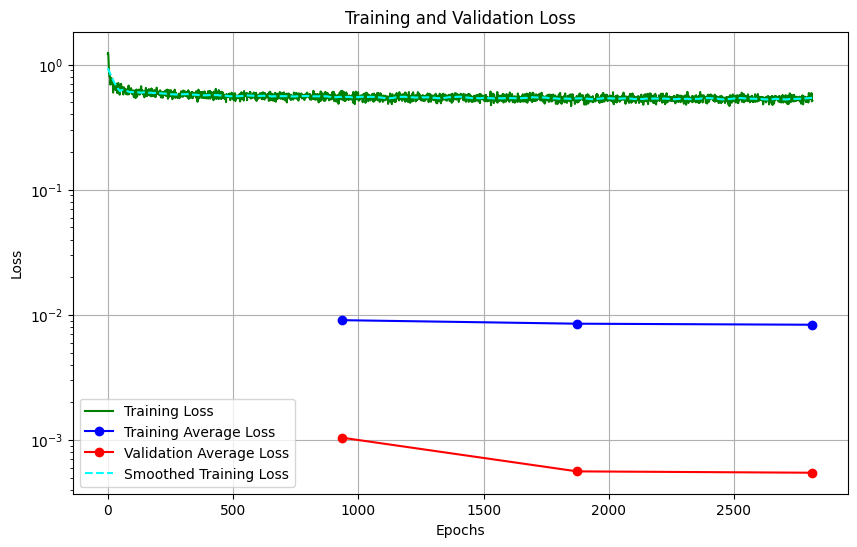

In [6]:
# Trainig 
epochs = 3
lr = .3
log_interval = 250

optimizer = optim.Adadelta(AE_model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


tr_loss = []
tr_loss_step = []
test_loss = []
if use_cuda: 
    AE_model = AE_model.cuda()
for epoch in range(1, epochs + 1):
    # Validate 
    if epoch % 3 == 0:
        validate(model=AE_model, use_cuda=use_cuda, test_loader=test_loader, test_loss=test_loss, plot=True)
    else:
        validate(model=AE_model, use_cuda=use_cuda, test_loader=test_loader, test_loss=test_loss, plot=False)
    # train one epoch
    train_loss_tmp = []
    train(model=AE_model, use_cuda=use_cuda, train_loader=train_loader, optimizer=optimizer,
          epoch=epoch, log_interval=log_interval, tr_loss=train_loss_tmp)
    for i in range(len(train_loss_tmp)):
        tr_loss_step.append(train_loss_tmp[i])
    tr_loss.append(np.sum(train_loss_tmp).item() / len(train_loader.dataset))
    print(f'Train Epoch: {epoch} \t Average: {tr_loss[-1]:.8f}')

    scheduler.step(test_loss[-1])

plot_training(tr_loss_step, tr_loss, test_loss, epochs, train_loader, batch_size)

    

## 02 VAE (2P)

The AE is a self-supervised network often used in outlier detection. However, since we do not know the AE's latent state, we can not generate new samples from it. 

We visualised the latent of your trained AE with the following plot. You should see some Clusters; however, many of the individual classes overlap heavily or are not well separated.

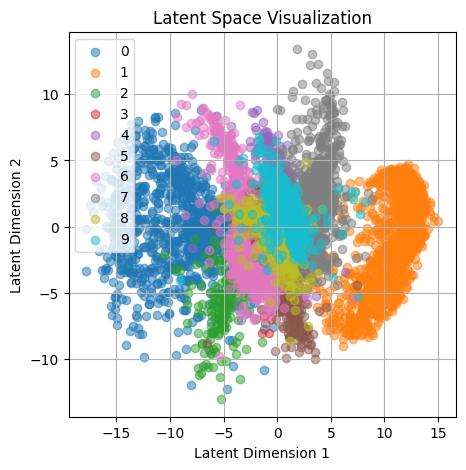

In [7]:

AE_model.eval()

# Calculate Latents out of test dataset
latents = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        if use_cuda: 
            data = data.cuda()
        _, _, z = AE_model(data)
        latents.append(z.detach().cpu())
        labels.append(target)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

# Visualize these latents in a simple plot
plt.figure(figsize=(5, 5))
for i in range(10):
    idxs = labels == i
    plt.scatter(latents[idxs, 0], latents[idxs, 1], label=str(i), alpha=0.5)

plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.grid(True)
plt.show()

With a VAE (Variational Auto Encoder), we restrict the latent to follow a Gaussian distribution.
After training, we can sample random points of the Gaussian latent and use the decoder to generate new images. 

To do so, we need to make some adjustments to the AE. 
To not write everything from scratch again, we use object-orientated programming.

For the VAE, we need to add a parametrisation and sampling function and rewrite the loss_function and forward function. 

To restrict the latent to a Gaussian, we use the latent to predict the mean and logarithmic variance (for stability reasons) of a Gaussian.
We then, during training, use the sampling function to sample a random point using the predicted mean and variance. 
The sampled value is then decoded by the decoder for the output image. 

Because we can not train this with the MSE loss anymore, we make use of the KL-divergence (for information, read <a href="https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73">here</a>). 
Therefore, adjust the loss function to follow: 
 $$ KL(N(\mu, \sigma), N(0, 1)) + MSE_{Loss} = 0.5 * \frac{\sum ( \mu^2 + \sigma - \log \sigma - 1)}{\textrm{Num. samples}} + 0.5 * \sum (\textrm{Input} - \textrm{Prediction})^2 $$

In [15]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import List
import torchvision.transforms as TT
import numpy as np
from torchsummary import summary

class VAE(nn.Module):
    '''
    Implementation of a Variational Autoencoder (VAE)
    -----------------------------
    in_channels: Number of input Channels (in our case number of image Channels)
    latent_dim: determines the size of the latent dimension
    input_size: np.array of H x W of input images 
    hidden_dim: List of channel sizes of the Encoder Decoder layers

    -----------------------------
    Will setup a VAE with encode, decode, forward, loss_function, sample and generate function
    '''
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 input_size: np.ndarray,
                 hidden_dims: List = None,
                 **kwargs) -> None:
    
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            self.hidden_dims = [32, 64, 128, 256]
        else: 
            self.hidden_dims = hidden_dims

        # Build Encoder
        for h_dim in self.hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)

        self.block_dimension = self.input_size 
        for i in range(len(self.hidden_dims)): 
            self.block_dimension = (self.block_dimension + 2 - 1) // 2

        self.fc_mu = nn.Linear(self.hidden_dims[-1] * self.block_dimension[0] * self.block_dimension[1], latent_dim)
        self.fc_var = nn.Linear(self.hidden_dims[-1] * self.block_dimension[0] * self.block_dimension[1], latent_dim)

        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, self.hidden_dims[-1] * self.block_dimension[0] * self.block_dimension[1])

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1], kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU()
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], hidden_dims[-1], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            TT.Resize((28, 28)),
            nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=1, padding=0),
            nn.Tanh()
        )

    def encode(self, input: Tensor) -> List[Tensor]:
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return [mu, log_var]

    def reparameterize(self, mu: Tensor, log_var: Tensor) -> Tensor:
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, self.hidden_dims[0], self.block_dimension[0], self.block_dimension[1])
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return [reconstruction, input, mu, log_var]

    def loss_function(self,
                      prediction: List[Tensor], 
                      target: Tensor, 
                      **kwargs) -> dict:
        reconstruction, input, mu, log_var = prediction
        mse_loss = nn.MSELoss(reduction='sum')
        recon_loss = mse_loss(reconstruction, target)
        
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        kl_div = kl_div / input.size(0)

        loss = recon_loss + kl_div
        return loss

    def generate(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        return self.decode(x)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
       BatchNorm2d-2           [-1, 32, 14, 14]              64
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,496
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
        LeakyReLU-12            [-1, 256, 2, 2]               0
           Linear-13                    [-1, 2]           2,050
           Linear-14                   

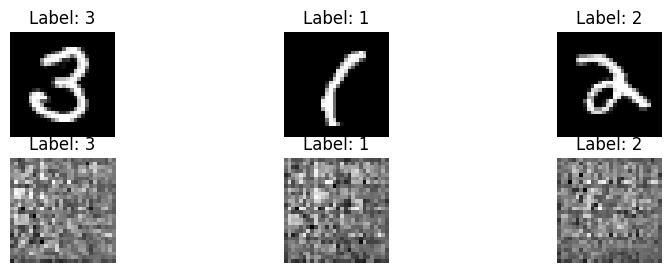

In [16]:
# Test your implementation
# You should see the original MNIST images and 2 noisy images below (since the AE is not trained yet)

VAE_model = VAE(in_channels=1, latent_dim=2, input_size=np.array([28, 28]), hidden_dims=[32, 64, 128, 256])

summary(VAE_model, input_size=(1, 28, 28), device='cpu')

data_instance = iter(train_loader)
images, labels = next(data_instance)

predicted_img, input, mu, log_var = VAE_model(images)

fig, axes = plt.subplots(2, 3, figsize=(10, 3))
for i in range(3):
    image = images[i].numpy().squeeze()  # Bild in numpy-Array umwandeln und Kanal dimension entfernen
    axes[0][i].imshow(image, cmap='gray')
    axes[0][i].set_title(f'Label: {labels[i].item()}')
    axes[0][i].axis('off')
    # Same for prediction
    pred_img = predicted_img[i].detach().numpy().squeeze()
    axes[1][i].imshow(pred_img, cmap='gray')
    axes[1][i].set_title(f'Label: {labels[i].item()}')
    axes[1][i].axis('off')
plt.show()


Test set: Average loss: 796.42000625

Train Epoch: 1 [0/60000 (0%)]	Loss: 55613.05078125
Train Epoch: 1 [16000/60000 (27%)]	Loss: 27863.50585938
Train Epoch: 1 [32000/60000 (53%)]	Loss: 27712.87109375
Train Epoch: 1 [48000/60000 (80%)]	Loss: 28402.50390625
Train Epoch: 1 	 Average: 446.78969865

Test set: Average loss: 422.69479688

Train Epoch: 2 [0/60000 (0%)]	Loss: 27481.79882812
Train Epoch: 2 [16000/60000 (27%)]	Loss: 28166.35546875
Train Epoch: 2 [32000/60000 (53%)]	Loss: 27900.05273438
Train Epoch: 2 [48000/60000 (80%)]	Loss: 26376.49804688
Train Epoch: 2 	 Average: 416.31091313

Test set: Average loss: 407.75383750

Train Epoch: 3 [0/60000 (0%)]	Loss: 29168.07031250
Train Epoch: 3 [16000/60000 (27%)]	Loss: 24892.58593750
Train Epoch: 3 [32000/60000 (53%)]	Loss: 25345.78515625
Train Epoch: 3 [48000/60000 (80%)]	Loss: 26274.12304688
Train Epoch: 3 	 Average: 406.77934570

Test set: Average loss: 407.47747187

Train Epoch: 4 [0/60000 (0%)]	Loss: 26492.88867188
Train Epoch: 4 [160

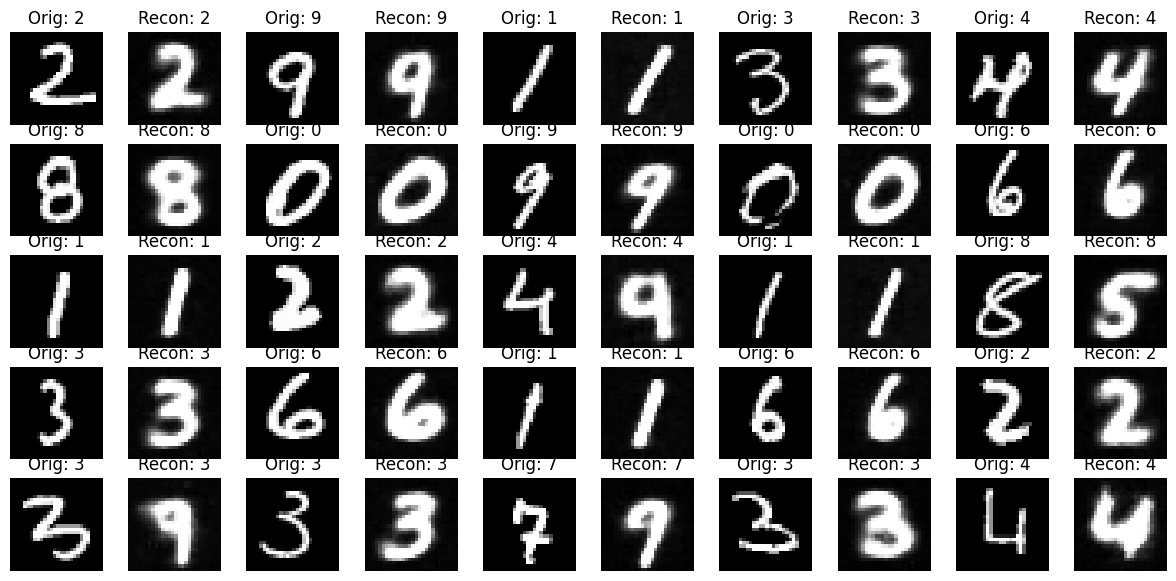

Train Epoch: 5 [0/60000 (0%)]	Loss: 27365.79687500
Train Epoch: 5 [16000/60000 (27%)]	Loss: 23300.60546875
Train Epoch: 5 [32000/60000 (53%)]	Loss: 26598.39453125
Train Epoch: 5 [48000/60000 (80%)]	Loss: 24375.39843750
Train Epoch: 5 	 Average: 397.98699784

Test set: Average loss: 396.72432187

Train Epoch: 6 [0/60000 (0%)]	Loss: 27546.99804688
Train Epoch: 6 [16000/60000 (27%)]	Loss: 26914.75390625
Train Epoch: 6 [32000/60000 (53%)]	Loss: 24274.97265625
Train Epoch: 6 [48000/60000 (80%)]	Loss: 24743.93554688
Train Epoch: 6 	 Average: 395.11131729

Test set: Average loss: 396.00939375

Train Epoch: 7 [0/60000 (0%)]	Loss: 24130.83398438
Train Epoch: 7 [16000/60000 (27%)]	Loss: 22915.71289062
Train Epoch: 7 [32000/60000 (53%)]	Loss: 25563.89062500
Train Epoch: 7 [48000/60000 (80%)]	Loss: 26461.99609375
Train Epoch: 7 	 Average: 393.03803306


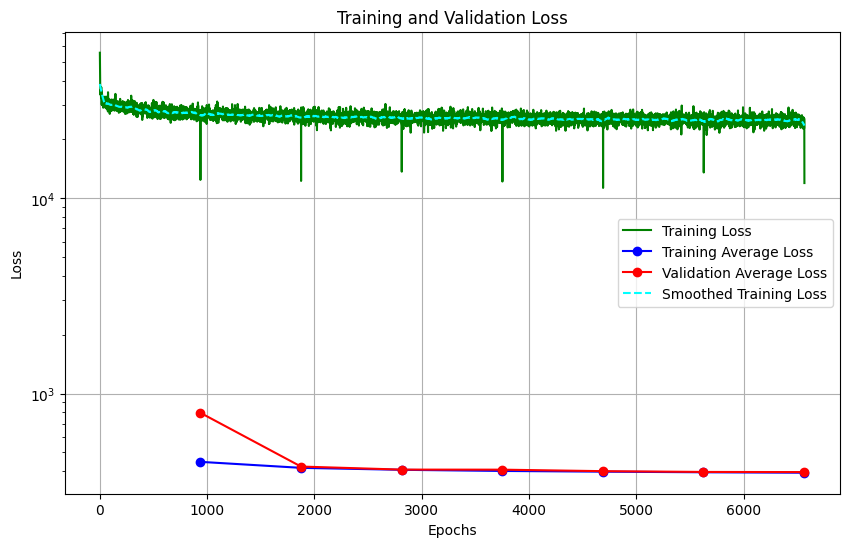

In [17]:
# Trainig 
epochs = 7
lr = 0.3
log_interval = 250

optimizer = optim.Adadelta(VAE_model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


tr_loss = []
tr_loss_step = []
test_loss = []
if use_cuda: 
    VAE_model = VAE_model.cuda()
for epoch in range(1, epochs + 1):
    # Validate 
    if epoch % 5 == 0:
        validate(model=VAE_model, use_cuda=use_cuda, test_loader=test_loader, test_loss=test_loss, plot=True)
    else:
        validate(model=VAE_model, use_cuda=use_cuda, test_loader=test_loader, test_loss=test_loss, plot=False)
    # train one epoch
    train_loss_tmp = []
    train(model=VAE_model, use_cuda=use_cuda, train_loader=train_loader, optimizer=optimizer,
          epoch=epoch, log_interval=log_interval, tr_loss=train_loss_tmp)
    
    for i in range(len(train_loss_tmp)):
        tr_loss_step.append(train_loss_tmp[i])
    tr_loss.append(np.sum(train_loss_tmp).item() / len(train_loader.dataset))
    print(f'Train Epoch: {epoch} \t Average: {tr_loss[-1]:.8f}')

    scheduler.step(test_loss[-1])

plot_training(tr_loss_step, tr_loss, test_loss, epochs, train_loader, batch_size)

    

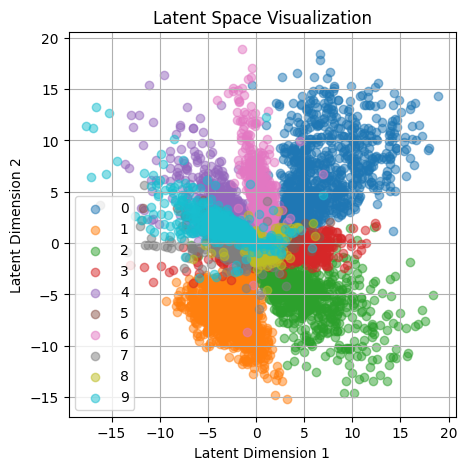

In [18]:

VAE_model.eval()

# Calculate Latents out of test dataset
latents = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        if use_cuda: 
            data = data.cuda()
        _, _, z, _ = VAE_model(data)
        latents.append(z.detach().cpu())
        labels.append(target)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

# Visualize these latents in a simple plot
plt.figure(figsize=(5, 5))
for i in range(10):
    idxs = labels == i
    plt.scatter(latents[idxs, 0], latents[idxs, 1], label=str(i), alpha=0.5)

plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.grid(True)
plt.show()



With this, your Data should look much more structured (much more centred around (0, 0), and clusters closer together).
Depending on your training time, this will get better with more epochs.

## 03 Visualize generated images (2P)

You are now asked to implement a grid over the latent space in the image above. 
Forward each point of the grid through the VAE and show the image.
The result should be an image consisting of multiple generated images. 
This is another visualisation of the Latent space. 


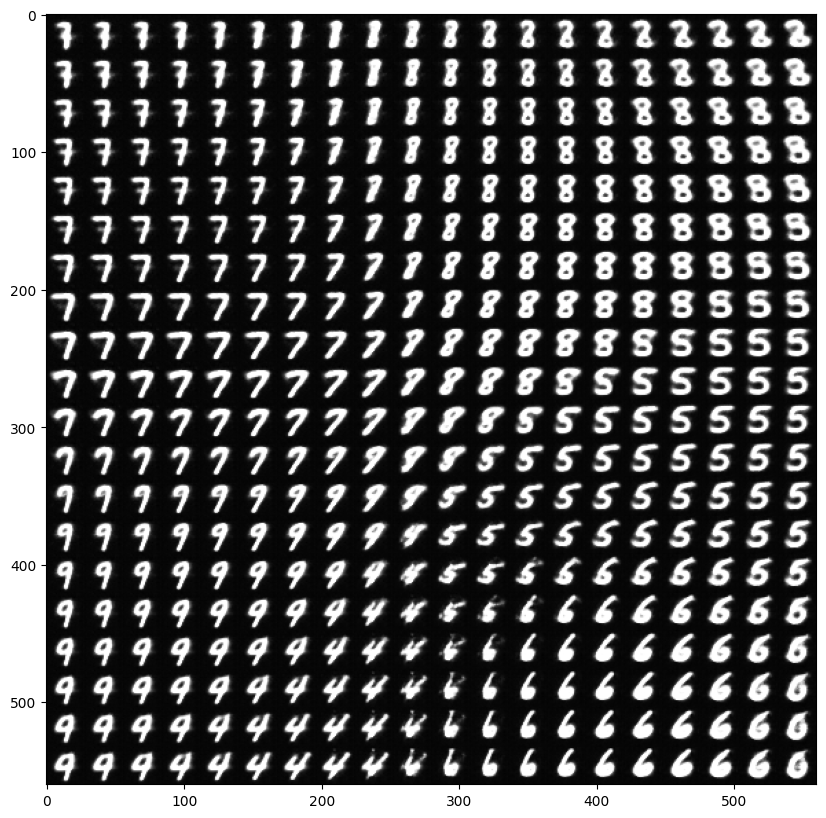

In [19]:
from scipy.stats import norm

# Define the number of images per dimension (nxn grid)
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Create a grid of points in the latent space
# We will sample n points uniformly spaced in the range of [-2, 2] for both dimensions
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

# Decode the grid points and arrange the decoded images in a large grid
with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32)
            if use_cuda:
                z_sample = z_sample.cuda()
            x_decoded = VAE_model.decode(z_sample)
            digit = x_decoded.cpu().numpy().squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

# Plot the resulting image
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.grid(False)
plt.show()
